In [15]:
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape, TimeDistributed

In [30]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def resize_feature(feature, target_shape):
    """Resize a 2D feature array to a target shape (height, width)."""
    from scipy.ndimage import zoom
    zoom_factors = (
        target_shape[0] / feature.shape[0],
        target_shape[1] / feature.shape[1],
    )
    return zoom(feature, zoom_factors)

def extract_features(file_path, max_len=100, visualize=False):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)

        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)

        # Fix time dimension to max_len
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            chroma = np.pad(chroma, ((0, 0), (0, pad_width)), mode='constant')
            mel = np.pad(mel, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
            chroma = chroma[:, :max_len]
            mel = mel[:, :max_len]

        # Resize all to same height (e.g., 40 rows)
        chroma_resized = resize_feature(chroma, (40, max_len))
        mel_resized = resize_feature(mel, (40, max_len))

        # Stack as channels: shape becomes (40, 100, 3)
        combined = np.stack([mfcc, chroma_resized, mel_resized], axis=-1)

        if visualize:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
            plt.title("MFCC")
            plt.subplot(1, 3, 2)
            librosa.display.specshow(chroma, sr=sample_rate, x_axis='time')
            plt.title("Chroma")
            plt.subplot(1, 3, 3)
            librosa.display.specshow(mel, sr=sample_rate, x_axis='time', y_axis='mel')
            plt.title("Mel")
            plt.tight_layout()
            plt.show()

        return combined  # shape: (40, 100, 3)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [35]:
data_dir = r"C:\Users\Sanjeev\Code\RAVDESS DATASET" 
emotions = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
features, labels = [], []

for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".wav"):
            emotion = emotions.get(file.split("-")[2], "unknown")
            feature = extract_features(os.path.join(root, file))
            if feature is not None:
                features.append(feature)  # shape: (40, 100, 3)
                labels.append(emotion)

# Convert to numpy arrays
X = np.array(features)                     # shape: (samples, 40, 100, 3)
y = np.array(labels)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("✅ Dataset prepared!")
print(f"X shape: {X.shape}, y shape: {y_encoded.shape}")



✅ Dataset prepared!
X shape: (1012, 40, 100, 3), y shape: (1012,)


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(40, 100, 3), padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # 8 emotion classes
])




c:\Users\Sanjeev\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 40, 100, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 20, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 20, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 10, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       983,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,077,448 (4.11 MB)

 Trainable params: 1,077,448 (4.11 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.1637 - loss: 21.9077 - val_accuracy: 0.1970 - val_loss: 1.9233
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.1434 - loss: 1.9723 - val_accuracy: 0.2020 - val_loss: 1.8580
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.1991 - loss: 1.9094 - val_accuracy: 0.1773 - val_loss: 1.8262
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.1950 - loss: 1.9004 - val_accuracy: 0.2020 - val_loss: 1.8040
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.1718 - loss: 1.8814 - val_accuracy: 0.2020 - val_loss: 1.8093
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.1966 - loss: 1.8570 - val_accuracy: 0.2069 - val_loss: 1.7741
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.1978 - loss: 1.8393 - val_accuracy: 0.2167 - val_loss: 1.7781
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.1815 - loss: 1.8325 - val_accuracy: 0.2118

In [46]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 40, 100, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 20, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 20, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 10, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       983,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,077,448 (4.11 MB)

 Trainable params: 1,077,448 (4.11 MB)

 Non-trainable params: 0 (0.00 B)

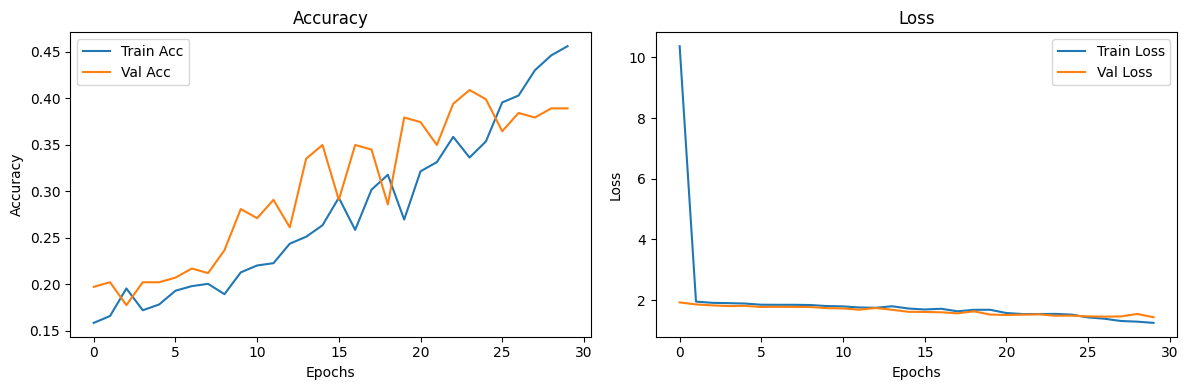

In [45]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



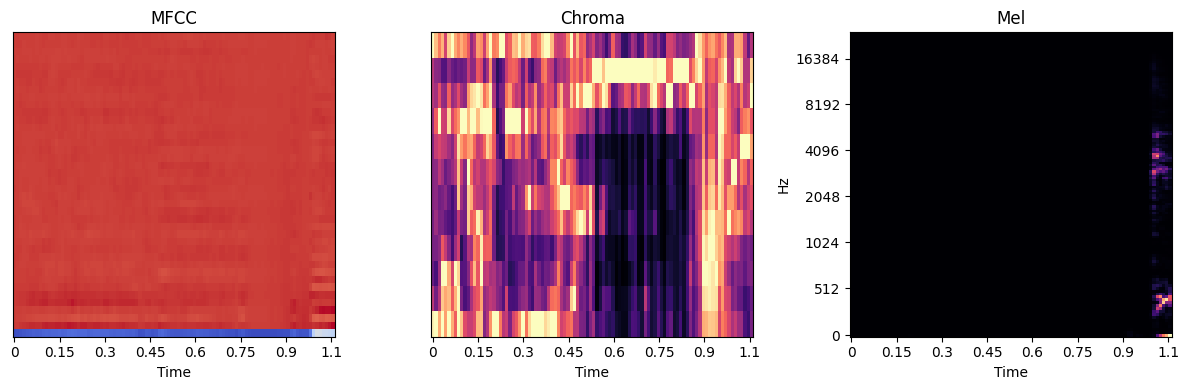

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Predicted Emotion: fearful


In [49]:


new_audio = r"c:\Users\Sanjeev\Code\RAVDESS DATASET\Actor_13\03-02-03-01-01-01-13.wav"
features = extract_features(new_audio, visualize=True)

if features is not None:
    # Reshape to match model input: (1, 40, 100, 3)
    features_reshaped = features.reshape(1, 40, 100, 3)

    # Predict emotion
    prediction = model.predict(features_reshaped)
    predicted_emotion = encoder.inverse_transform([np.argmax(prediction)])

    print(f"Predicted Emotion: {predicted_emotion[0]}")
else:
    print("Feature extraction failed.")

